In [118]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from ptb import lang_util
from util import activity_square
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from functools import reduce, partial
import matplotlib.pyplot as plt

In [119]:
reload(lang_util)
corpus = lang_util.Corpus('/Users/jgordon/nta/datasets/PTB')

print(corpus.read_out(corpus.train[:60]))

print(len(corpus.train), len(corpus.test))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former
929589 82430


In [120]:
import cv2
import os


def _plot_timeseries(inputs, memory, layers=2):
    steps = len(memory)
    fig, axs = plt.subplots(layers + 1, steps, dpi=144, figsize=(9, 3.3))
    for step in range(steps):
        for l in range(layers):
            ax = axs[l][step]
            ax.imshow(activity_square(memory[step][l, 0]))
            ax.axis('off')
        input_ax = axs[layers][step]
        input_ax.imshow(activity_square(inputs[step]))
        input_ax.axis('off')
    plt.show()
    
def _save_snapshot(x_b, layers=2, frames_dir='./snapshots', batch_item=0, step=0):
    fig, axs = plt.subplots(layers, 1, figsize=(3, 5))
    for l in range(layers):
        ax = axs[layers-l-1]
        ax.imshow(activity_square(x_b.detach()[l, batch_item]))
        ax.axis('off')
    plt.savefig(frames_dir + '/snap_batch%d_%d.png' % (batch_item, step))
    plt.close('all')
    
def timeseries_video(image_folder='./snapshots', video_name='stiched.avi'):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    video = cv2.VideoWriter(video_name, fourcc, 5.0, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()    

In [171]:
import rsm_samplers
import rsm
from ptb import lang_util
import rsm_experiment
reload(rsm_samplers)
reload(rsm)
reload(lang_util)
reload(rsm_experiment)

VISUAL_DEBUG = False
FLAT = True
ORSM = False

CONFIG = {
    'debug': False,
    'path': "/Users/jgordon/nta/results",
    'data_dir': "/Users/jgordon/nta/datasets",
    'dataset': 'ptb',
    'predictor_hidden_size': 200,
    'predictor_output_size': 10000,
    'batch_size': 300,
    'batches_in_epoch': 50,
    'batches_in_first_epoch': 5,
    'vocab_size': 10000,
    'embed_dim': 28,
    'input_size': (1, 28),
    'output_size': 28,
    'eval_interval': 3,
    'eval_batches_in_epoch': 270,
    'learning_rate': 0.0005,
    'pred_l2_reg': 0.00001,
    'input_bias': True,
    'eval_interval': 0,
    
    'eps': 0.0,
    'gamma': 0.0,
    'forget_mu': 0.02,
    'weight_sparsity': 0.3,
    'mult_integration': False,
    'fpartition': 0.15,
    'boost_strength_factor': 0.97,
    'boost_strat': 'col_boosting',
    'do_inhibition': False,
    'x_b_norm': True,
    'balance_part_winners': True,
    
    # Hierarchy
    'n_layers': 1,
    'feedback': True,
    'tp_boosting': False,
    'loss_layers': 'all_layers',
}

if FLAT:
    CONFIG.update({
        'm_groups': 300,
        'n_cells_per_group': 1,
        'k_winners': 10,
        'k_winner_cells': 1
    })
else:
    CONFIG.update({
        'm_groups': 200,
        'n_cells_per_group': 4,
        'k_winners': 15
    })
if ORSM:
    CONFIG.update({
        'boost_strat': 'rsm_inhibition',
        'do_inhibition': True,
        'fpartition': None
    })
    
if VISUAL_DEBUG:
    CONFIG.update({
        "visual_debug": True,
        "batch_size": 1,
        "batches_in_first_epoch": 1,
        "batches_in_epoch": 1
    })
    
exp = rsm_experiment.RSMExperiment(config=CONFIG)
exp.corpus = corpus
exp.model_setup(CONFIG)

setup: Using cpu
Maybe download PTB...
Built dataloaders...
Created <RSMLayer m=300 n=1 k=10 d_in=28 eps=0.00 partition=(0.15,0.85) /> with 86488 trainable params
Created RSMNet with 1 layer(s)


Gradients [0, 0, 0]


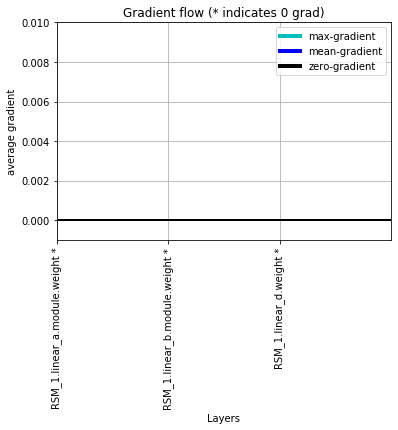

Breaking after 5 batches in epoch 0
0 {'stop': 0, 'train_loss': 0.4031272292137146, 'train_pred_ppl': 10017.871920844453, 'train_pred_acc': 0.0, 'epoch_time_train': 1.1745550632476807, 'epoch_time': 1.174678087234497, 'learning_rate': 0.0005}
Gradients [tensor(0.0029), tensor(0.0021), tensor(0.0038)]


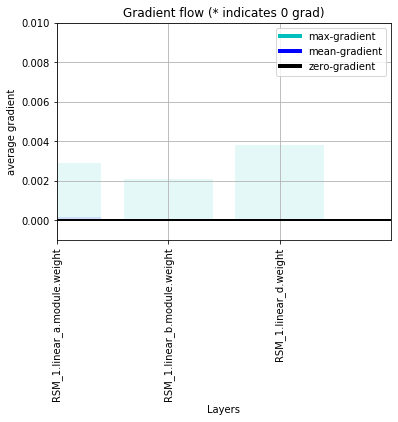

1 {'stop': 0, 'train_loss': 0.4820180296897888, 'train_pred_ppl': 9608.287796374227, 'train_pred_acc': 2.18, 'epoch_time_train': 12.443474054336548, 'epoch_time': 12.443611860275269, 'learning_rate': 0.0005}
Gradients [tensor(0.0063), tensor(0.0010), tensor(0.0073)]


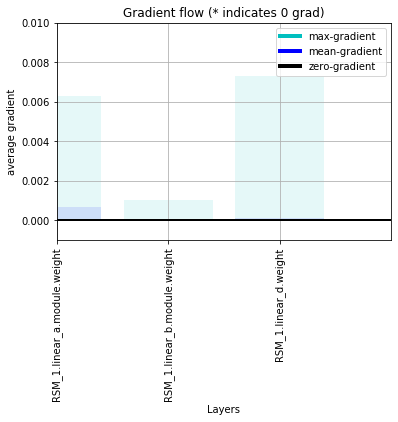

2 {'stop': 0, 'train_loss': 0.4237150126695633, 'train_pred_ppl': 7570.520030087633, 'train_pred_acc': 4.866666666666666, 'epoch_time_train': 12.991330862045288, 'epoch_time': 12.991468667984009, 'learning_rate': 0.0005}
Gradients [tensor(0.0116), tensor(0.0024), tensor(0.0064)]


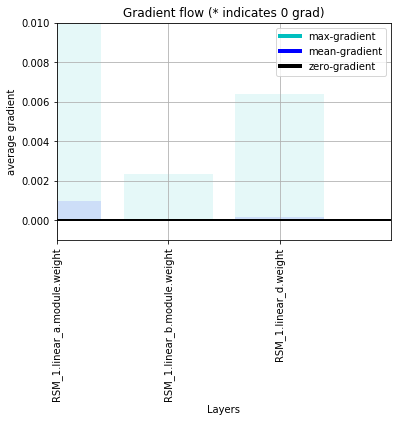

3 {'stop': 0, 'train_loss': 0.3436081713438034, 'train_pred_ppl': 4167.330043087446, 'train_pred_acc': 5.493333333333333, 'epoch_time_train': 12.802942037582397, 'epoch_time': 12.803072929382324, 'learning_rate': 0.0005}
Gradients [tensor(0.0091), tensor(0.0022), tensor(0.0098)]


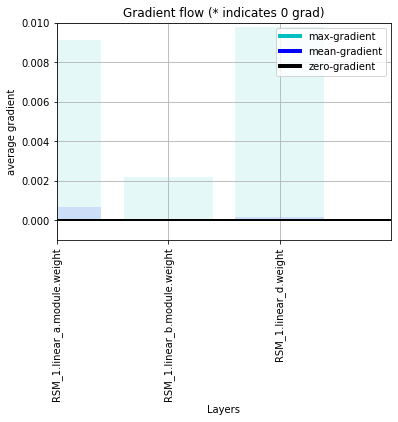

4 {'stop': 0, 'train_loss': 0.2712184923887253, 'train_pred_ppl': 1732.2340379147615, 'train_pred_acc': 4.6066666666666665, 'epoch_time_train': 12.970282077789307, 'epoch_time': 12.970410108566284, 'learning_rate': 0.0005}
Gradients [tensor(0.0032), tensor(0.0017), tensor(0.0066)]


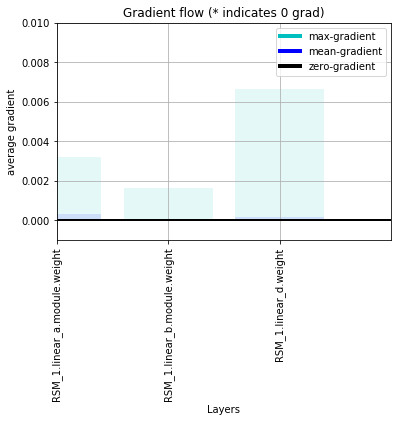

5 {'stop': 0, 'train_loss': 0.225459945499897, 'train_pred_ppl': 926.527131219046, 'train_pred_acc': 5.453333333333333, 'epoch_time_train': 12.590003967285156, 'epoch_time': 12.590135097503662, 'learning_rate': 0.0005}
Gradients [tensor(0.0008), tensor(0.0010), tensor(0.0050)]


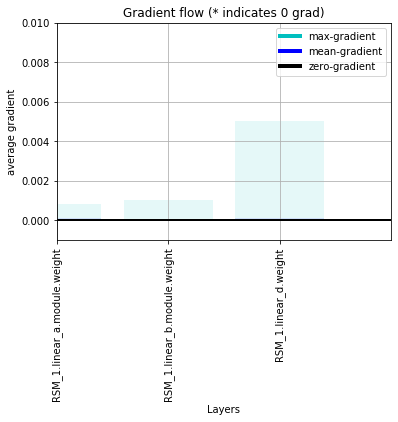

6 {'stop': 0, 'train_loss': 0.20467426121234894, 'train_pred_ppl': 874.4735727194613, 'train_pred_acc': 5.1866666666666665, 'epoch_time_train': 12.926001071929932, 'epoch_time': 12.926126956939697, 'learning_rate': 0.0005}
Gradients [tensor(0.0003), tensor(0.0005), tensor(0.0035)]


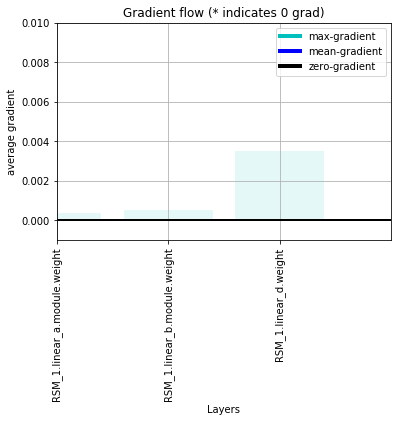

7 {'stop': 0, 'train_loss': 0.19637535780668258, 'train_pred_ppl': 840.829548105544, 'train_pred_acc': 5.6866666666666665, 'epoch_time_train': 12.894577264785767, 'epoch_time': 12.894705295562744, 'learning_rate': 0.0005}
Gradients [tensor(0.0003), tensor(0.0004), tensor(0.0029)]


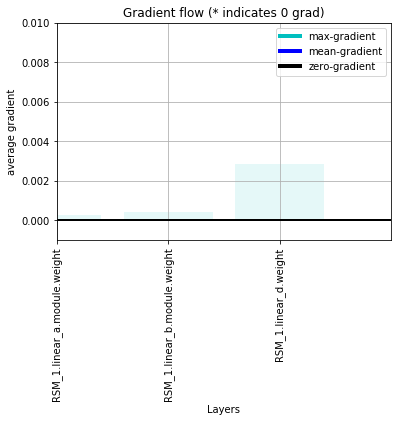

8 {'stop': 0, 'train_loss': 0.19375323474407197, 'train_pred_ppl': 817.4227996416396, 'train_pred_acc': 5.24, 'epoch_time_train': 12.955893993377686, 'epoch_time': 12.956018209457397, 'learning_rate': 0.0005}
Gradients [tensor(0.0002), tensor(0.0002), tensor(0.0017)]


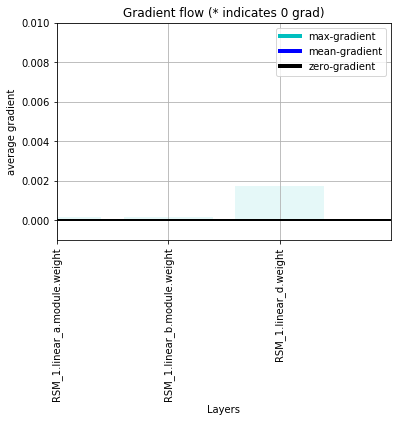

9 {'stop': 0, 'train_loss': 0.19385420322418212, 'train_pred_ppl': 831.3561085949556, 'train_pred_acc': 5.36, 'epoch_time_train': 13.004395961761475, 'epoch_time': 13.004524946212769, 'learning_rate': 0.0005}
Gradients [tensor(0.0002), tensor(0.0002), tensor(0.0018)]


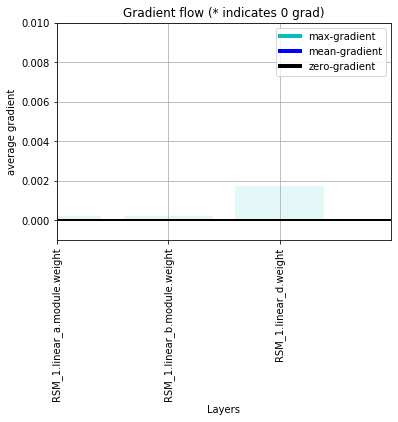

10 {'stop': 0, 'train_loss': 0.19189986020326613, 'train_pred_ppl': 780.3348925449683, 'train_pred_acc': 5.413333333333333, 'epoch_time_train': 12.71967887878418, 'epoch_time': 12.719811916351318, 'learning_rate': 0.0005}
Gradients [tensor(0.0002), tensor(0.0003), tensor(0.0022)]


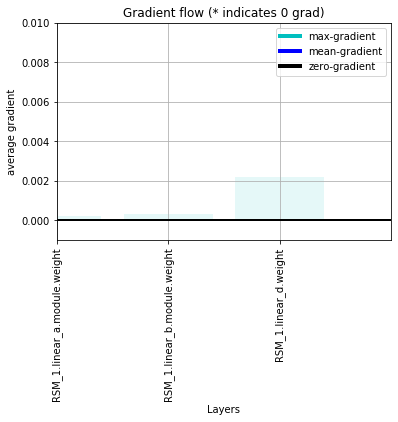

11 {'stop': 0, 'train_loss': 0.19260763078927995, 'train_pred_ppl': 803.0310212378942, 'train_pred_acc': 5.273333333333333, 'epoch_time_train': 13.035643100738525, 'epoch_time': 13.035767078399658, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0002), tensor(0.0018)]


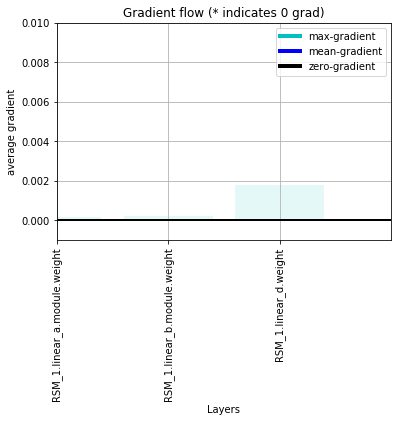

12 {'stop': 0, 'train_loss': 0.19240043491125106, 'train_pred_ppl': 787.5079624926807, 'train_pred_acc': 5.406666666666666, 'epoch_time_train': 12.833801031112671, 'epoch_time': 12.833929061889648, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0003), tensor(0.0024)]


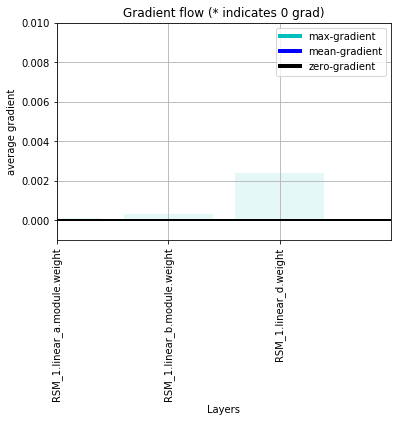

13 {'stop': 0, 'train_loss': 0.19199422240257263, 'train_pred_ppl': 781.1549987021168, 'train_pred_acc': 5.446666666666666, 'epoch_time_train': 13.045337200164795, 'epoch_time': 13.045465230941772, 'learning_rate': 0.0005}
Gradients [tensor(0.0003), tensor(0.0002), tensor(0.0020)]


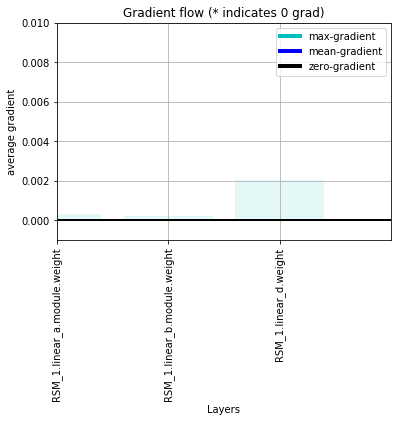

14 {'stop': 0, 'train_loss': 0.19163677334785462, 'train_pred_ppl': 759.2054997857066, 'train_pred_acc': 5.233333333333333, 'epoch_time_train': 12.999279975891113, 'epoch_time': 12.999406099319458, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0002), tensor(0.0024)]


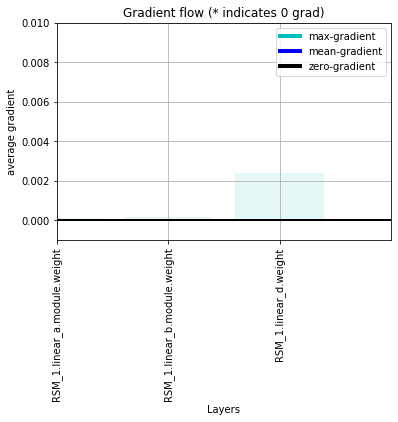

15 {'stop': 0, 'train_loss': 0.1914076629281044, 'train_pred_ppl': 766.0967665462125, 'train_pred_acc': 5.986666666666666, 'epoch_time_train': 13.421862125396729, 'epoch_time': 13.421996116638184, 'learning_rate': 0.0005}
Gradients [tensor(0.0002), tensor(0.0002), tensor(0.0019)]


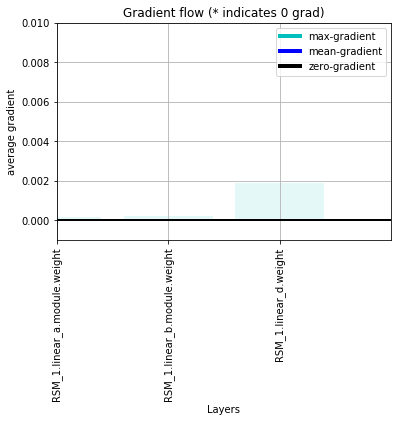

16 {'stop': 0, 'train_loss': 0.19163512498140334, 'train_pred_ppl': 752.1308910555468, 'train_pred_acc': 5.506666666666667, 'epoch_time_train': 13.547636032104492, 'epoch_time': 13.547765970230103, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0002), tensor(0.0020)]


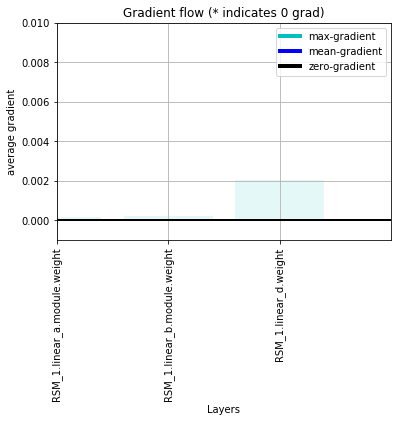

17 {'stop': 0, 'train_loss': 0.1911661458015442, 'train_pred_ppl': 758.7522590281619, 'train_pred_acc': 5.36, 'epoch_time_train': 13.421555280685425, 'epoch_time': 13.421679258346558, 'learning_rate': 0.0005}
Gradients [tensor(0.0002), tensor(0.0002), tensor(0.0023)]


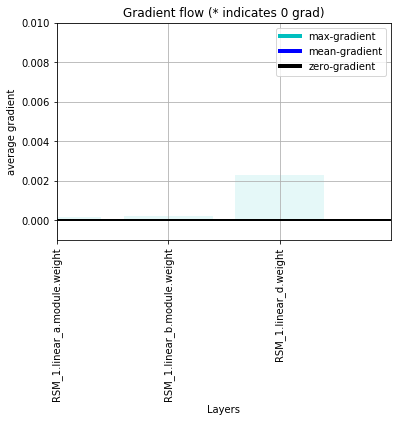

18 {'stop': 0, 'train_loss': 0.19234064906835557, 'train_pred_ppl': 764.3720313327972, 'train_pred_acc': 5.306666666666667, 'epoch_time_train': 13.121412754058838, 'epoch_time': 13.121543884277344, 'learning_rate': 0.0005}
Gradients [tensor(8.6388e-05), tensor(0.0001), tensor(0.0023)]


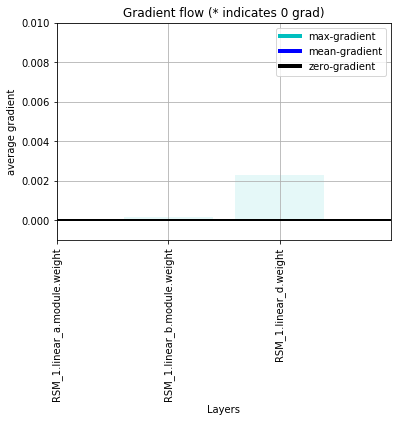

19 {'stop': 0, 'train_loss': 0.19236101180315018, 'train_pred_ppl': 778.8615702722205, 'train_pred_acc': 5.593333333333334, 'epoch_time_train': 13.17155408859253, 'epoch_time': 13.171690940856934, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0002), tensor(0.0024)]


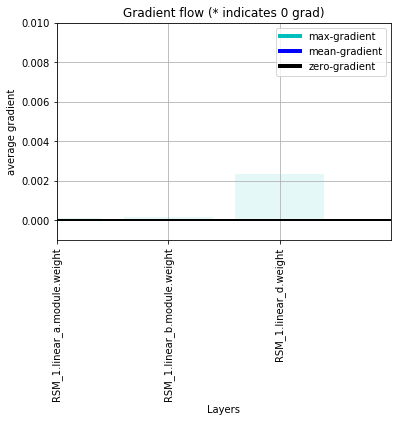

20 {'stop': 0, 'train_loss': 0.19167061239480973, 'train_pred_ppl': 744.1832240564642, 'train_pred_acc': 5.826666666666667, 'epoch_time_train': 13.139267206192017, 'epoch_time': 13.139405012130737, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0002), tensor(0.0017)]


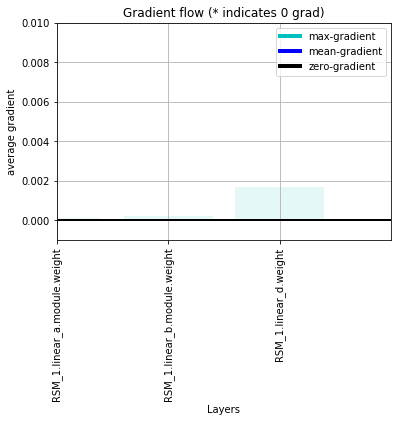

21 {'stop': 0, 'train_loss': 0.19069604873657225, 'train_pred_ppl': 727.0630255577743, 'train_pred_acc': 5.64, 'epoch_time_train': 13.06306004524231, 'epoch_time': 13.063189029693604, 'learning_rate': 0.0005}
Gradients [tensor(0.0002), tensor(0.0001), tensor(0.0020)]


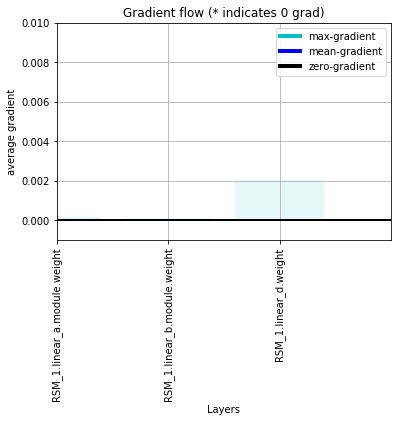

22 {'stop': 0, 'train_loss': 0.19159636825323104, 'train_pred_ppl': 758.6494999541978, 'train_pred_acc': 5.48, 'epoch_time_train': 12.828412771224976, 'epoch_time': 12.828539848327637, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0001), tensor(0.0015)]


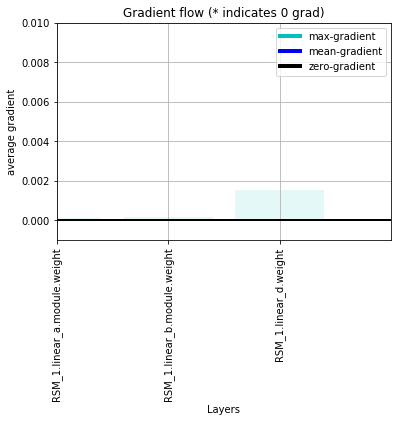

23 {'stop': 0, 'train_loss': 0.19132021933794022, 'train_pred_ppl': 731.8863750459531, 'train_pred_acc': 5.613333333333333, 'epoch_time_train': 13.15373706817627, 'epoch_time': 13.15386700630188, 'learning_rate': 0.0005}
Gradients [tensor(0.0001), tensor(0.0001), tensor(0.0020)]


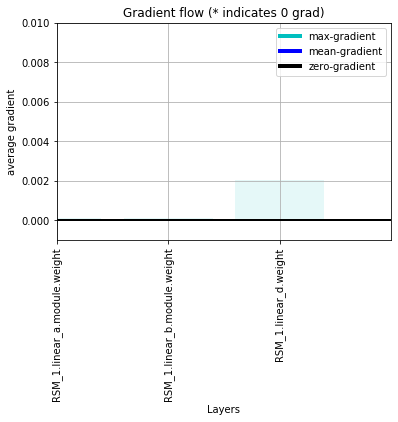

KeyboardInterrupt: 

In [172]:
input_timeseries = []
memory_timeseries = []
TIMESTEPS = 10
import util
reload(util)
from util import _plot_grad_flow

def fwd_hook(mod, input_tuple, output_tuple):
    inputs, prior_hidden = input_tuple
    out, hidden = output_tuple
    x_b = hidden[0]
#     _save_snapshot(x_b, layers=mod.n_layers, step=mod.batch_counter)

# exp.model.register_forward_hook(fwd_hook)

EPOCHS = 50

for epoch in range(EPOCHS):
    _plot_grad_flow(exp.model)
    plt.show()
    exp.train_epoch(epoch)

In [ ]:
timeseries_video()

#### Confirming cross-epoch sequence continuity

In [ ]:
collate_fn = partial(rsm_samplers.ptb_pred_sequence_collate, vector_dict=bwe.embedding_dict)

sampler = rsm_samplers.PTBSequenceSampler(corpus.train, batch_size=10, max_batches=1)
loader = DataLoader(corpus.train,
                       batch_sampler=sampler,
                       collate_fn=collate_fn)


EPOCHS = 50

last_output = None

sequence = []
for i in range(EPOCHS):
    total_loss = 0.0
    input_timeseries = []
    memory_timeseries = []

    for batch_id, (inputs, target, pred_target, pred_input) in enumerate(loader):
        sequence.append(pred_input[0].item())

print(corpus.read_out(sequence))
print(len(sequence))

In [90]:
x = torch.rand(3, 10)
y = torch.rand(3, 10)
print(x)
print(y)
catted = torch.cat((x.unsqueeze(0), y.unsqueeze(0)), 0)
print(catted.size())

tensor([[0.8996, 0.2029, 0.0077, 0.1016, 0.1167, 0.5233, 0.5660, 0.7953, 0.1819,
         0.3351],
        [0.9901, 0.4842, 0.6215, 0.1780, 0.8878, 0.6848, 0.6886, 0.8453, 0.2977,
         0.0327],
        [0.6607, 0.6927, 0.2667, 0.9015, 0.6293, 0.5844, 0.2408, 0.7229, 0.6885,
         0.1949]])
tensor([[0.4374, 0.8911, 0.4127, 0.0035, 0.2117, 0.0145, 0.7387, 0.3790, 0.3167,
         0.6313],
        [0.7924, 0.4317, 0.2592, 0.5413, 0.4986, 0.1481, 0.6069, 0.7135, 0.9809,
         0.7554],
        [0.0663, 0.6803, 0.0186, 0.6123, 0.6040, 0.2357, 0.3059, 0.3596, 0.9920,
         0.2359]])
torch.Size([2, 3, 10])


In [176]:
data_len = 82430
batch_size = 10
(data_len/batch_size * torch.range(0, batch_size-1)).long()

/Users/jgordon/miniconda3/envs/standard/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([    0,  8243, 16486, 24729, 32972, 41215, 49458, 57701, 65944, 74187])